In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
import kagglehub
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns 
import pandas as pd  
from sklearn.metrics import confusion_matrix 

In [ ]:
try:
    path = kagglehub.dataset_download("alessiocorrado99/animals10")
    data_dir = str(path) + "/raw-img"
    print(f"Dataset 'Animals10' descargado en: {data_dir}")
except Exception as e:
    print(f"Error al descargar desde Kaggle Hub. {e}")
    data_dir = "./raw-img"

# 1. Transformación con Data Augmentation (solo para entrenamiento)
train_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(), 
    transforms.RandomRotation(15),      
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# 2. Transformación estándar (para validación y prueba)
val_test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Cargamos el dataset completo usando la transformación estándar
full_dataset = datasets.ImageFolder(root=data_dir, transform=val_test_transform)


total_size = len(full_dataset)
test_size = int(0.10 * total_size)
train_val_size = total_size - test_size
val_size = int(0.10 * train_val_size)
train_size = train_val_size - val_size

train_val_data, test_data = torch.utils.data.random_split(full_dataset, [train_val_size, test_size])
train_data, val_data = torch.utils.data.random_split(train_val_data, [train_size, val_size])


train_data.dataset.transform = train_transform


print(f"Tamaño de Entrenamiento: {len(train_data)}")
print(f"Tamaño de Validación: {len(val_data)}")
print(f"Tamaño de Prueba: {len(test_data)}")

batch_size_setting = 64

train_loader = DataLoader(train_data, batch_size=batch_size_setting, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size_setting, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size_setting, shuffle=False)

Using Colab cache for faster access to the 'animals10' dataset.
Dataset 'Animals10' descargado en: /kaggle/input/animals10/raw-img
Tamaño de Entrenamiento: 21206
Tamaño de Validación: 2356
Tamaño de Prueba: 2617


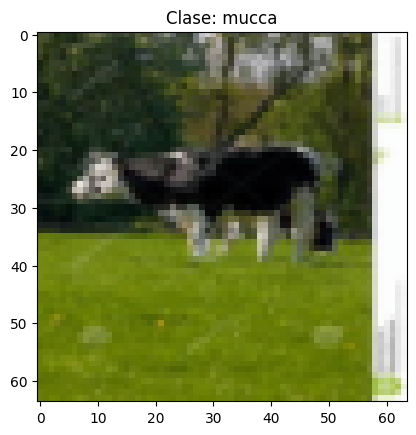

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

dataiter = iter(train_loader)
images, labels = next(dataiter)

image = images[0]

image_np = image.numpy().transpose((1, 2, 0))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
image_np = std * image_np + mean
image_np = np.clip(image_np, 0, 1) 

plt.imshow(image_np)
plt.title(f'Clase: {full_dataset.classes[labels[0]]}') 
plt.show()
#

In [ ]:
import torchvision.models as models

class ResNetTransferFineTuneDeeper(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNetTransferFineTuneDeeper, self).__init__()

        self.model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

        for param in self.model.parameters():
            param.requires_grad = False

    
        for param in self.model.layer4.parameters():
            param.requires_grad = True

        for param in self.model.layer3.parameters():
            param.requires_grad = True

        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Linear(num_ftrs, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, num_classes) 
        )

    def forward(self, x):
        return self.model(x)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = ResNetTransferFineTuneDeeper(num_classes=10).to(device)

loss_fn = nn.CrossEntropyLoss()

optimizer = optim.Adam(net.parameters(), lr=0.00005) 

print(f"Configuración de Prueba 5: Modelo=ResNet-18 (Fine-Tuning Profundo, L3+L4), Optimizador=Adam, LR=5e-5")

Configuración de Prueba 5: Modelo=ResNet-18 (Fine-Tuning Profundo, L3+L4), Optimizador=Adam, LR=5e-5


In [ ]:
class EarlyStopper:
    def __init__(self, patience=5, min_delta=0):
        """
        Inicializa el Early Stopper.
        :param patience: Número de épocas a esperar después de que no haya mejora.
        :param min_delta: Cambio mínimo para ser considerado una mejora.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        """
        Verifica si se debe detener el entrenamiento.
        """
        if validation_loss < self.min_validation_loss - self.min_delta:
            self.min_validation_loss = validation_loss
            self.counter = 0  # Reiniciar el contador si hay mejora
        elif validation_loss > self.min_validation_loss + self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

early_stopper = EarlyStopper(patience=5, min_delta=0.001)

num_epochs = 50 
history = {'train_loss': [], 'val_loss': [], 'val_accuracy': []} 

print(f"Comenzando el entrenamiento en {device}...")

for epoch in range(num_epochs):

    net.train() # Modo entrenamiento (activa Dropout)
    epoch_train_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad() 

        output = net(images)

        # Calcular la pérdida
        loss = loss_fn(output, labels)

        # Retropropagación y Actualización de pesos
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()

    avg_train_loss = epoch_train_loss / len(train_loader)

    net.eval() 
    epoch_val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad(): 
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            output = net(images)
            loss = loss_fn(output, labels)

            epoch_val_loss += loss.item()

            _, predicted = torch.max(output.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_val_loss = epoch_val_loss / len(val_loader)
    val_accuracy = 100 * correct / total

    history['train_loss'].append(avg_train_loss)
    history['val_loss'].append(avg_val_loss)
    history['val_accuracy'].append(val_accuracy)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')

    if early_stopper.early_stop(avg_val_loss):
        print(f"Parada anticipada en la Época {epoch+1}. Sin mejora durante {early_stopper.patience} épocas.")
        break

Comenzando el entrenamiento en cuda...
Epoch 1/50, Train Loss: 1.1794, Val Loss: 0.6318, Val Acc: 79.41%
Epoch 2/50, Train Loss: 0.5501, Val Loss: 0.5355, Val Acc: 82.43%
Epoch 3/50, Train Loss: 0.3043, Val Loss: 0.5543, Val Acc: 83.15%
Epoch 4/50, Train Loss: 0.1455, Val Loss: 0.6002, Val Acc: 82.34%
Epoch 5/50, Train Loss: 0.0697, Val Loss: 0.6448, Val Acc: 82.85%
Epoch 6/50, Train Loss: 0.0383, Val Loss: 0.7197, Val Acc: 82.26%
Epoch 7/50, Train Loss: 0.0301, Val Loss: 0.7623, Val Acc: 82.17%
Parada anticipada en la Época 7. Sin mejora durante 5 épocas.


Accuracy Final en Test (Prueba 2): 67.48%


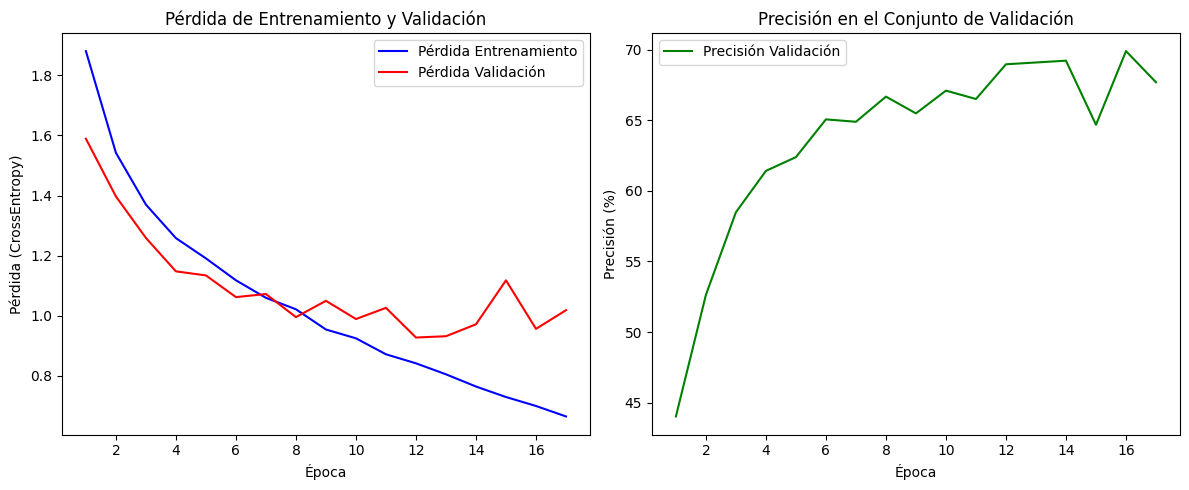

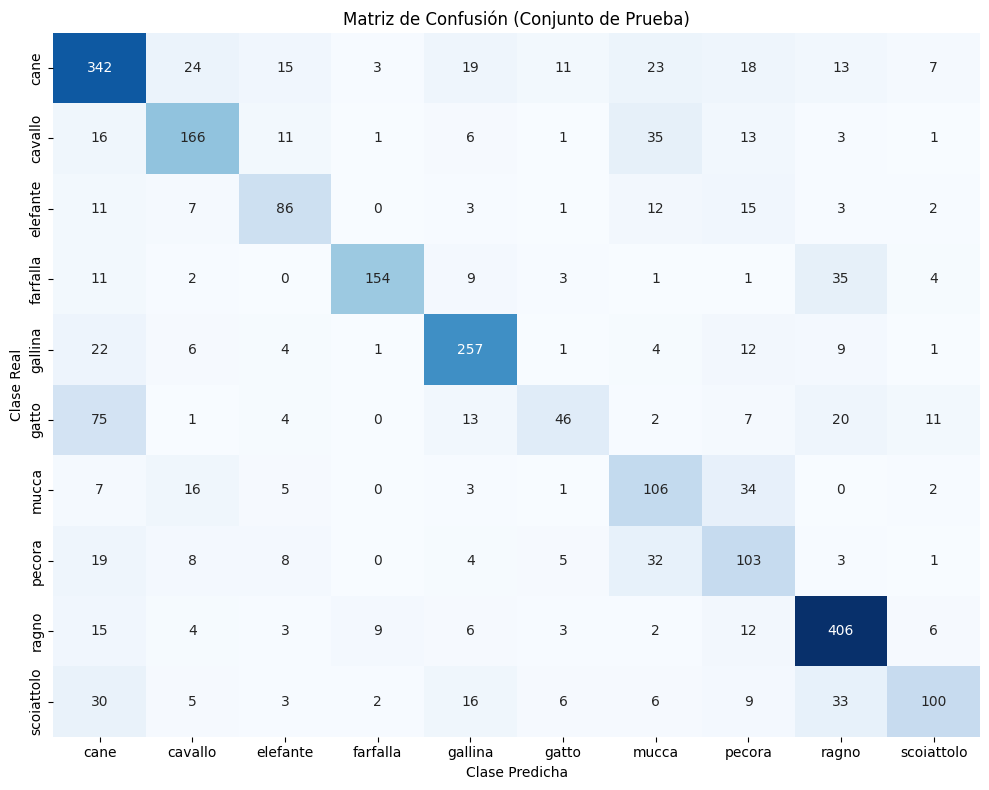


Se han generado las gráficas de Pérdida/Precisión y la Matriz de Confusión.


In [ ]:
net.eval() 
correct = 0
total = 0
all_labels = []
all_predicted = []

with torch.no_grad():
  for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    total += labels.size(0)

    output = net(images)
    _, predicted = torch.max(output.data, 1)

    correct += (predicted == labels).sum().item()

    # Guardar para la matriz de confusión
    all_labels.extend(labels.cpu().numpy())
    all_predicted.extend(predicted.cpu().numpy())

final_accuracy = 100 * correct / total
print(f'Accuracy Final en Test (Prueba 2): {final_accuracy:.2f}%')

epochs_run = len(history['train_loss'])
epochs = range(1, epochs_run + 1)

plt.figure(figsize=(12, 5))

# Gráfica de Pérdida
plt.subplot(1, 2, 1)
plt.plot(epochs, history['train_loss'], 'b-', label='Pérdida Entrenamiento')
plt.plot(epochs, history['val_loss'], 'r-', label='Pérdida Validación')
plt.title('Pérdida de Entrenamiento y Validación')
plt.xlabel('Época')
plt.ylabel('Pérdida (CrossEntropy)')
plt.legend()

# Gráfica de Precisión
plt.subplot(1, 2, 2)
plt.plot(epochs, history['val_accuracy'], 'g-', label='Precisión Validación')
plt.title('Precisión en el Conjunto de Validación')
plt.xlabel('Época')
plt.ylabel('Precisión (%)')
plt.legend()

plt.tight_layout()
plt.show() 
plt.close()


classes = full_dataset.classes
cm = confusion_matrix(all_labels, all_predicted)
cm_df = pd.DataFrame(cm, index = classes, columns = classes)

plt.figure(figsize=(10, 8))

sns.heatmap(cm_df, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.title('Matriz de Confusión (Conjunto de Prueba)')
plt.ylabel('Clase Real')
plt.xlabel('Clase Predicha')
plt.tight_layout()
plt.show() # Muestra la matriz de confusión
plt.close()

print("\nSe han generado las gráficas de Pérdida/Precisión y la Matriz de Confusión.")